# CRBMs in Tensorflow

## CRBM training and testing algorithms, in TensorFlow

@authors Josep Ll. Berral (Barcelona Supercomputing Center)

@date 27th June, 2018

@license GNU GPL v3 (or posterior) <http://www.gnu.org/licenses/>


Here you can find a Conditional Restricted Boltzmann Machines, for academic and educational purposes. Two versions are presented:
* CRBM with explicit conditioner
* Extension of CRBM considering inputs as Time-Series (conditioner = "history")

### References

* Approach based on Graham Taylor's CRBM: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/gwtaylor_nips.pdf

### Mocap data

* Original file: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat
* Data originally from Eugene Hsu, MIT. http://people.csail.mit.edu/ehsu/work/sig05stf/

In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import sys

#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import HTML, display

## Auxiliar functions

* Xavier Glorot's initialization method
* Sampling Bernoulli
* Sampling Gaussian

In [2]:
def glorot_init(fan_in, fan_out, const = 1.0, dtype = np.float32):
    k = const * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = -k, maxval = k, dtype = dtype)

In [3]:
def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

def sample_gaussian(x, sigma):
    return x + tf.random_normal(tf.shape(x), mean = 0.0, stddev = sigma, dtype = tf.float32)

## CRBM definitions

### Generic multi-purpose CRBM

Constructor:
* creates the CRBM structure and TF execution tree. Defines the number of visible units (inputs), number of condition units (static inputs) and number of hidden units, also the hyperparameters.

Training:
* **fit**: trains the CRBM using the provided inputs and condition inputs
* **evaluate_error**: evaluates the reconstruction error of passing data forward and backward through the CRBM

Predicting/Reconstructing:
* **forward**: propagates the inputs and condition inputs through the CRBM towards the hidden layer activations
* **backward**: propagates the activations and condition inputs through the CRBM backwards to the visible layer input reconstructions
* **forward_backward**: propagates the inputs and condition inputs through the CRBM towards the hidden layer activations, then the activations and condition inputs backwards to the visible layer input reconstructions
* **gibbs_sampling**: reconstructs inputs using Gibbs sampling passing inputs forward and backward the CRBM

Setters and Getters:
* **get_weights**: gets the weights of the CRBM for an external source
* **set_weights**: sets the weights of the CRBM from an external source
* **save_weights**: saves the weights of the CRBM into a file
* **load_weights**: loads the weights of the CRBM from a file

In [4]:
## Gaussian-Bernoulli Conditional-RBM
class CRBM:
    
    # Constructor of CRBM, define execution plan and launch TF
    def __init__(self, n_visible, n_condition, n_hidden, learning_rate = 0.01, momentum = 0.8):
        assert momentum >= 0.0 and momentum <= 1
        assert learning_rate >= 0.0 and learning_rate < 1
        
        '''
        Initialize CRBM variables
        '''
        self.n_visible     = n_visible
        self.n_hidden      = n_hidden
        self.n_condition   = n_condition
        self.learning_rate = learning_rate
        self.momentum      = momentum
        
        self.x = tf.placeholder(tf.float32, [None, self.n_visible])
        self.y = tf.placeholder(tf.float32, [None, self.n_hidden])
        self.c = tf.placeholder(tf.float32, [None, self.n_condition])
        
        self.w     = tf.Variable(glorot_init(self.n_visible, self.n_hidden), dtype = tf.float32)
        self.vbias = tf.Variable(tf.zeros([self.n_visible]), dtype = tf.float32)
        self.hbias = tf.Variable(tf.zeros([self.n_hidden]), dtype = tf.float32)
        
        self.a     = tf.Variable(glorot_init(self.n_condition, self.n_visible), dtype = tf.float32)
        self.b     = tf.Variable(glorot_init(self.n_condition, self.n_hidden), dtype = tf.float32)
        
        self.delta_w     = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype = tf.float32)
        self.delta_vbias = tf.Variable(tf.zeros([self.n_visible]), dtype = tf.float32)
        self.delta_hbias = tf.Variable(tf.zeros([self.n_hidden]), dtype = tf.float32)
        
        self.delta_a     = tf.Variable(tf.zeros([self.n_condition, self.n_visible]), dtype = tf.float32)
        self.delta_b     = tf.Variable(tf.zeros([self.n_condition, self.n_hidden]), dtype = tf.float32)
        
        '''
        TF execution plan for Contrastive Divergence-k
        '''
        # compute positive phase
        ph_mean = tf.nn.sigmoid(tf.matmul(self.x, self.w) + tf.matmul(self.c, self.b) + self.hbias)
        ph_sample = sample_bernoulli(ph_mean)
        
        # compute negative phase (k = 1)
        nv = tf.matmul(ph_sample, tf.transpose(self.w)) + tf.matmul(self.c, self.a) + self.vbias
        nh_mean = tf.nn.sigmoid(tf.matmul(nv, self.w) + tf.matmul(self.c, self.b) + self.hbias)
        nh_sample = sample_bernoulli(nh_mean)
        
        # determine gradients on CRBM parameters
        gradient_w = tf.matmul(tf.transpose(self.x), ph_mean) - tf.matmul(tf.transpose(nv), nh_mean)
        gradient_v = tf.reduce_mean(self.x - nv, 0)
        gradient_h = tf.reduce_mean(ph_mean - nh_mean, 0)
        gradient_a = tf.matmul(tf.transpose(self.c), self.x) - tf.matmul(tf.transpose(self.c), nv)
        gradient_b = tf.matmul(tf.transpose(self.c), ph_mean) - tf.matmul(tf.transpose(self.c), nh_mean)
        
        new_delta_w     = self.momentum * self.delta_w     + (1 - self.momentum) * self.learning_rate * gradient_w / tf.to_float(tf.shape(gradient_w)[0])
        new_delta_vbias = self.momentum * self.delta_vbias + (1 - self.momentum) * self.learning_rate * gradient_v / tf.to_float(tf.shape(gradient_v)[0])
        new_delta_hbias = self.momentum * self.delta_hbias + (1 - self.momentum) * self.learning_rate * gradient_h / tf.to_float(tf.shape(gradient_h)[0])
        new_delta_a     = self.momentum * self.delta_a     + (1 - self.momentum) * self.learning_rate * gradient_a / tf.to_float(tf.shape(gradient_a)[0])
        new_delta_b     = self.momentum * self.delta_b     + (1 - self.momentum) * self.learning_rate * gradient_b / tf.to_float(tf.shape(gradient_b)[0])
        
        # update weights and deltas
        update_delta_w     = self.delta_w.assign(new_delta_w)
        update_delta_vbias = self.delta_vbias.assign(new_delta_vbias)
        update_delta_hbias = self.delta_hbias.assign(new_delta_hbias)
        update_delta_a     = self.delta_a.assign(new_delta_a)
        update_delta_b     = self.delta_b.assign(new_delta_b)
        
        update_w     = self.w.assign(self.w + new_delta_w)
        update_vbias = self.vbias.assign(self.vbias + new_delta_vbias)
        update_hbias = self.hbias.assign(self.hbias + new_delta_hbias)
        update_a     = self.a.assign(self.a + new_delta_a)
        update_b     = self.b.assign(self.b + new_delta_b)
        
        self.update_deltas  = [update_delta_w, update_delta_vbias, update_delta_hbias, update_delta_a, update_delta_b]
        self.update_weights = [update_w, update_vbias, update_hbias, update_a, update_b]
        
        '''
        TF execution plan for passing data forward and backward
        '''
        # compute values forward and backward
        self.activation_mean   = tf.nn.sigmoid(tf.matmul(self.x, self.w) + tf.matmul(self.c, self.b) + self.hbias)
        self.activation_sample = sample_bernoulli(self.activation_mean)
        self.reconstruction    = tf.matmul(self.activation_sample, tf.transpose(self.w)) + tf.matmul(self.c, self.a) + self.vbias
        self.decodification    = tf.matmul(self.y, tf.transpose(self.w)) + tf.matmul(self.c, self.a) + self.vbias
        
        # approximation to the reconstruction error
        self.compute_err = tf.reduce_mean(tf.square(self.x - self.reconstruction))
        
        '''
        Initialize TF Session
        '''
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
    
    # Forward and Backward functions
    def forward(self, data_x, data_c):
        assert data_x.shape[0] == data_c.shape[0]
        return self.sess.run(self.activation_sample, feed_dict = {self.x: data_x, self.c: data_c})
    
    def backward(self, data_y, data_c):
        assert data_y.shape[0] == data_c.shape[0]
        return self.sess.run(self.decodification, feed_dict = {self.y: data_y, self.c: data_c})
    
    def forward_backward(self, data_x, data_c):
        assert data_x.shape[0] == data_c.shape[0]
        return self.sess.run(self.reconstruction, feed_dict = {self.x: data_x, self.c: data_c})
    
    def evaluate_error(self, data_x, data_c):
        assert data_x.shape[0] == data_c.shape[0]
        return self.sess.run(self.compute_err, feed_dict = {self.x: data_x, self.c: data_c})
    
    # Gibbs sampling for data generation
    def gibbs_sampling(self, data_x, data_c, n_gibbs = 30):
        assert data_x.shape[0] == data_c.shape[0]
        assert n_gibbs > 0
        
        # Positive phase
        ph_mean = tf.nn.sigmoid(tf.matmul(self.x, self.w) + tf.matmul(self.c, self.b) + self.hbias)
        ph_sample = sample_bernoulli(ph_mean)
        
        # Negative phase
        nh_sample = ph_sample
        for i in range(n_gibbs):
            nv = tf.matmul(nh_sample, tf.transpose(self.w)) + tf.matmul(self.c, self.a) + self.vbias
            nh_mean = tf.nn.sigmoid(tf.matmul(nv, self.w) + tf.matmul(self.c, self.b) + self.hbias)
            nh_sample = sample_bernoulli(nh_mean)
        self.last_reconstructed = nv
        
        return self.sess.run(self.last_reconstructed, feed_dict = {self.x: data_x, self.c: data_c})
    
    # How to train your CRBM
    def fit(self, data_x, data_c, n_epochs = 10, batch_size = 10, verbose = True):
        assert n_epochs > 0
        assert data_x.shape[0] == data_c.shape[0]
        assert self.n_visible == data_x.shape[1] and self.n_visible * self.delay == data_c.shape[1]
        
        n_data = data_x.shape[0]
        
        if batch_size > 0:
            n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
        else:
            n_batches = 1
        
        data_x_cpy = data_x.copy()
        data_c_cpy = data_c.copy()
        inds = np.arange(n_data)
        
        errs = []
        
        for e in range(n_epochs):
            
            np.random.shuffle(inds)
            data_x_cpy = data_x_cpy[inds]
            data_c_cpy = data_c_cpy[inds]
            
            r_batches = range(n_batches)
            epoch_errs = np.zeros((n_batches,))
            epoch_errs_ptr = 0
            
            for b in r_batches:
                batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                batch_c = data_c_cpy[b * batch_size:(b + 1) * batch_size]
                self.sess.run(self.update_weights + self.update_deltas, feed_dict = {self.x: batch_x, self.c: batch_c})
                epoch_errs[epoch_errs_ptr] = self.sess.run(self.compute_err, feed_dict = {self.x: batch_x, self.c: batch_c})
                epoch_errs_ptr += 1
            
            if verbose:
                print('Epoch: {:d}'.format(e), 'Train error: {:.4f}'.format(epoch_errs.mean()))
                sys.stdout.flush()
            
            errs = np.hstack([errs, epoch_errs])
        
        return errs
    
    # Additional functions
    def get_weights(self):
        return self.sess.run(self.w), self.sess.run(self.vbias), self.sess.run(self.hbias), self.sess.run(self.a), self.sess.run(self.b)
    
    def save_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w, name + '_v': self.vbias, name + '_h': self.hbias, name + '_a': self.a, name + '_b': self.b})
        return saver.save(self.sess, filename)
    
    def set_weights(self, w, vbias, hbias, a, b):
        self.sess.run(self.w.assign(w))
        self.sess.run(self.vbias.assign(vbias))
        self.sess.run(self.hbias.assign(hbias))
        self.sess.run(self.a.assign(a))
        self.sess.run(self.b.assign(b))
    
    def load_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w, name + '_v': self.vbias, name + '_h': self.hbias, name + '_a': self.a, name + '_b': self.b})
        saver.restore(self.sess, filename)

### Time-series CRBM

Extra functions of the TS-CRBM:
* **fit**: inherits from the CRBM. Condition inputs are automatically generated as the delay-history for each input. The input data can be composed by different series, so series lenghts should be introduced.
* **build-history**: internal function that generates the conditioning history data for each point. This function is called by the other functions.
* **forecast**: given an input data point and its history, generates _n_ following steps using Gibbs sampling using the CRBM

In [5]:
class CRBM_Series(CRBM):
    # Override Constructor
    def __init__(self, n_visible, n_hidden, delay = 6, learning_rate = 0.01, momentum = 0.8):
        assert delay > 0
        
        self.delay = delay       
        CRBM.__init__(self, n_visible, n_visible * delay, n_hidden, learning_rate, momentum)
    
    def build_history(self, data_x, seqlen = None):
        if seqlen is None:
            seqlen = [data_x.shape[0]]
        data_x_new = np.empty((0,self.n_visible))
        data_c = np.empty((0, self.n_visible * self.delay))
        idx = 0
        for s in seqlen:
            if s > self.delay:
                data_xs = data_x[idx:(idx + s),:]
                data_cs = np.zeros((data_xs.shape[0] - self.delay, self.n_visible * self.delay))
                for i in range(self.delay, data_xs.shape[0]):
                    data_cs[(i - self.delay),:] = data_xs[(i - self.delay):i,:].reshape((self.n_visible * self.delay))
                data_xs = np.matrix(data_xs[self.delay:,:],)
                data_x_new = np.append(data_x_new, data_xs, axis = 0)
                data_c = np.append(data_c, data_cs, axis = 0)
            idx = idx + s
        return data_x_new, data_c
    
    # Override Forward and Backward functions
    def forward(self, data_x, seqlen = None, data_c = None):
        if data_c is None:
            data_x, data_c = self.build_history(data_x, seqlen)
        return super(CRBM_Series, self).forward(data_x, data_c)
    
    def forward_backward(self, data_x, seqlen = None, data_c = None):
        if data_c is None:
            data_x, data_c = self.build_history(data_x, seqlen)
        return super(CRBM_Series, self).forward_backward(data_x, data_c)
    
    def evaluate_error(self, data_x, seqlen = None, data_c = None):
        if data_c is None:
            data_x, data_c = self.build_history(data_x, seqlen)
        return super(CRBM_Series, self).evaluate_error(data_x, data_c)
    
    # Override Gibbs sampling for data generation
    def gibbs_sampling(self, data_x, seqlen = None, data_c = None, n_gibbs = 30):
        if data_c is None:
            data_x, data_c = self.build_history(data_x, seqlen)
        return super(CRBM_Series, self).gibbs_sampling(data_x, data_c, n_gibbs)
    
    # Forecast n steps using Gibbs sampling for data generation
    def forecast(self, data_x, n_samples = 10, n_gibbs = 30):
        assert n_gibbs > 0 and n_samples > 0
        
        vis = tf.identity(self.x)
        for h in range(n_gibbs):
            hid_mean = tf.nn.sigmoid(tf.matmul(vis, self.w) + tf.matmul(self.c, self.b) + self.hbias)
            hid_sample = sample_bernoulli(hid_mean)
            vis = tf.matmul(hid_sample, tf.transpose(self.w)) + tf.matmul(self.c, self.a) + self.vbias
            vis = tf.clip_by_value(vis, -2, 2)
        self.generate_op = vis
        
        sequence = np.zeros([n_samples, self.n_visible], dtype = float)
        
        persist_window = data_x[-1 - self.delay:,:].reshape((self.delay + 1) * self.n_visible)
        
        for t in range(n_samples):
            sequence[t,:] = self.sess.run(self.generate_op,
                                          feed_dict = {
                                              self.x: np.matrix((persist_window[:self.n_visible])),
                                              self.c: np.matrix((persist_window[self.n_visible:]))
                                          })
            persist_window = np.append(persist_window[self.n_visible:], sequence[t,:].copy())
        
        return sequence
    
    # How to train your CRBM_Series
    def fit(self, data_x, seqlen = None, data_c = None, n_epochs = 10, batch_size = 10, verbose = True):
        if data_c is None:
            data_x, data_c = self.build_history(data_x, seqlen)
        return super(CRBM_Series, self).fit(data_x, data_c, n_epochs, batch_size, verbose)

## An example: The Motion Example

We are testing now the CRBM with a fragment of the Motion Dataset, from Eugene Hsu <a href="http://people.csail.mit.edu/ehsu/work/sig05stf/">Styles of Human Motion</a>; a dataset capturing human motion from different body sensors (108 features), from different styles of walking. As we are not using the full dataset, we are using the fragment that Graham Taylor used in his works when validating CRBMs <a href="http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat">here</a>.

### Load Data

In [6]:
import scipy.io

def load_motion(filename):
    
    # load data
    mat_dict = scipy.io.loadmat(filename)
    Motion = mat_dict['Motion']
    
    n_seq = Motion.shape[1]
    
    # assume data is MIT format for now
    indx = np.r_[
        np.arange(0,6),np.arange(6,9),13,np.arange(18,21),25,np.arange(30,33),37,np.arange(42,45),49,np.arange(54,57),np.arange(60,63),
        np.arange(66,69),np.arange(72,75),np.arange(78,81),np.arange(84,87),np.arange(90,93),np.arange(96,99),np.arange(102,105)]
    
    row1 = Motion[0,0][0]
    
    offsets =   np.r_[
        row1[None,9:12],row1[None,15:18],row1[None,21:24],row1[None,27:30],row1[None,33:36],row1[None,39:42],
        row1[None,45:48],row1[None,51:54],row1[None,57:60],row1[None,63:66],row1[None,69:72],row1[None,75:78],
        row1[None,81:84],row1[None,87:90],row1[None,93:96],row1[None,99:102],row1[None,105:108]]
    
    # collapse sequences
    batchdata = np.concatenate([m[:, indx] for m in Motion.flat], axis=0)
    
    data_mean = batchdata.mean(axis = 0)
    data_std = batchdata.std(axis = 0)
    
    batchdata = (batchdata - data_mean) / data_std
    
    # get sequence lengths
    seqlen = [s.shape[0] for s in Motion.flat]
    
    return batchdata, seqlen, data_mean, data_std

In [7]:
batchdata, seqlen, data_mean, data_std = load_motion('motion.mat')

### Training

In [8]:
n_hidden      = 100
n_visible     = 49
learning_rate = 0.01
momentum      = 0.8
delay         = 6
n_epochs      = 300
batch_size    = 100

In [9]:
crbm1 = CRBM_Series(n_visible, n_hidden, delay, learning_rate, momentum)

In [10]:
err1 = crbm1.fit(batchdata, seqlen, n_epochs = n_epochs, batch_size = batch_size, verbose = True)

Epoch: 0 Train error: 1.1755
Epoch: 1 Train error: 0.6392
Epoch: 2 Train error: 0.5229
Epoch: 3 Train error: 0.4626
Epoch: 4 Train error: 0.4252
Epoch: 5 Train error: 0.3963
Epoch: 6 Train error: 0.3738
Epoch: 7 Train error: 0.3564
Epoch: 8 Train error: 0.3418
Epoch: 9 Train error: 0.3265
Epoch: 10 Train error: 0.3166
Epoch: 11 Train error: 0.3043
Epoch: 12 Train error: 0.2969
Epoch: 13 Train error: 0.2896
Epoch: 14 Train error: 0.2840
Epoch: 15 Train error: 0.2765
Epoch: 16 Train error: 0.2734
Epoch: 17 Train error: 0.2688
Epoch: 18 Train error: 0.2655
Epoch: 19 Train error: 0.2570
Epoch: 20 Train error: 0.2559
Epoch: 21 Train error: 0.2501
Epoch: 22 Train error: 0.2457
Epoch: 23 Train error: 0.2418
Epoch: 24 Train error: 0.2437
Epoch: 25 Train error: 0.2404
Epoch: 26 Train error: 0.2374
Epoch: 27 Train error: 0.2302
Epoch: 28 Train error: 0.2282
Epoch: 29 Train error: 0.2295
Epoch: 30 Train error: 0.2250
Epoch: 31 Train error: 0.2232
Epoch: 32 Train error: 0.2237
Epoch: 33 Train erro

Epoch: 268 Train error: 0.1391
Epoch: 269 Train error: 0.1410
Epoch: 270 Train error: 0.1395
Epoch: 271 Train error: 0.1409
Epoch: 272 Train error: 0.1490
Epoch: 273 Train error: 0.1398
Epoch: 274 Train error: 0.1401
Epoch: 275 Train error: 0.1389
Epoch: 276 Train error: 0.1397
Epoch: 277 Train error: 0.1425
Epoch: 278 Train error: 0.1384
Epoch: 279 Train error: 0.1422
Epoch: 280 Train error: 0.1391
Epoch: 281 Train error: 0.1386
Epoch: 282 Train error: 0.1391
Epoch: 283 Train error: 0.1388
Epoch: 284 Train error: 0.1394
Epoch: 285 Train error: 0.1404
Epoch: 286 Train error: 0.1385
Epoch: 287 Train error: 0.1371
Epoch: 288 Train error: 0.1400
Epoch: 289 Train error: 0.1385
Epoch: 290 Train error: 0.1388
Epoch: 291 Train error: 0.1392
Epoch: 292 Train error: 0.1393
Epoch: 293 Train error: 0.1383
Epoch: 294 Train error: 0.1384
Epoch: 295 Train error: 0.1384
Epoch: 296 Train error: 0.1372
Epoch: 297 Train error: 0.1377
Epoch: 298 Train error: 0.1382
Epoch: 299 Train error: 0.1373


### Predicting Forward-Backward

In [11]:
pred1 = crbm1.forward_backward(batchdata, seqlen = seqlen)

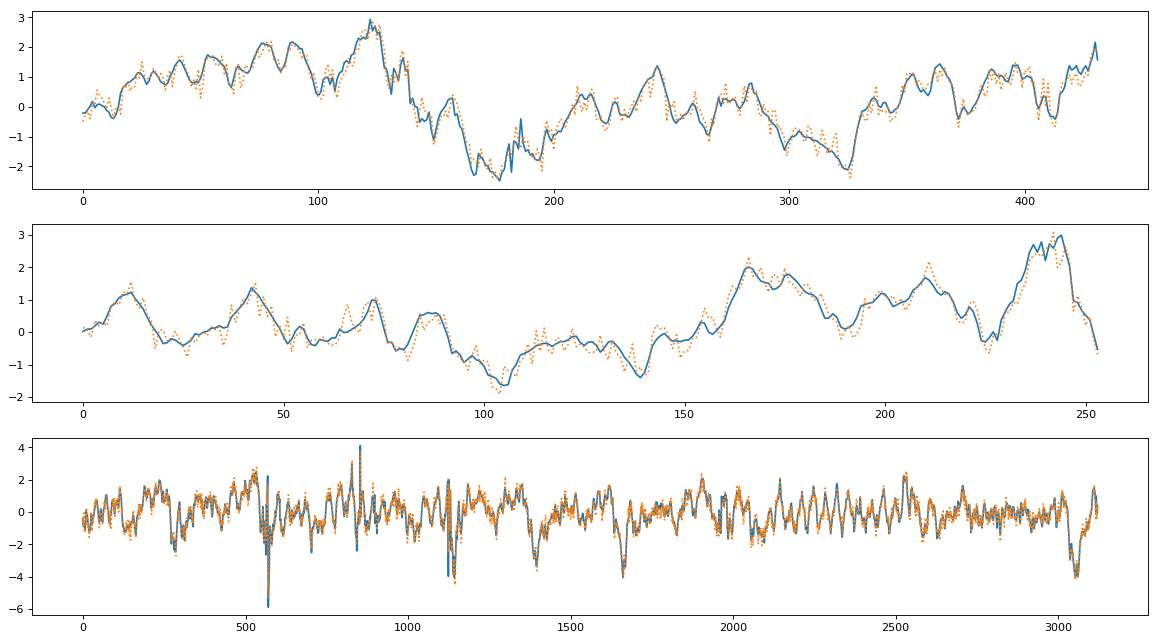

In [12]:
fig = plt.figure(figsize = (18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

count = 0
idx_real = 0
idx_pred = 0
for s in seqlen:
    plt.subplot(len(seqlen), 1, count+1)
    plt.plot(batchdata[(idx_real + crbm1.delay):(idx_real + s), 0], label = 'true', linestyle = '-')
    plt.plot(pred1[idx_pred:(idx_pred + s - crbm1.delay), 0], label = 'predict', linestyle = ':')
    count = count + 1
    idx_real = idx_real + s
    idx_pred = idx_pred + s - crbm1.delay

### Predicting with Gibb sampling

In [13]:
samp1 = crbm1.gibbs_sampling(batchdata, seqlen = seqlen, n_gibbs = 30)

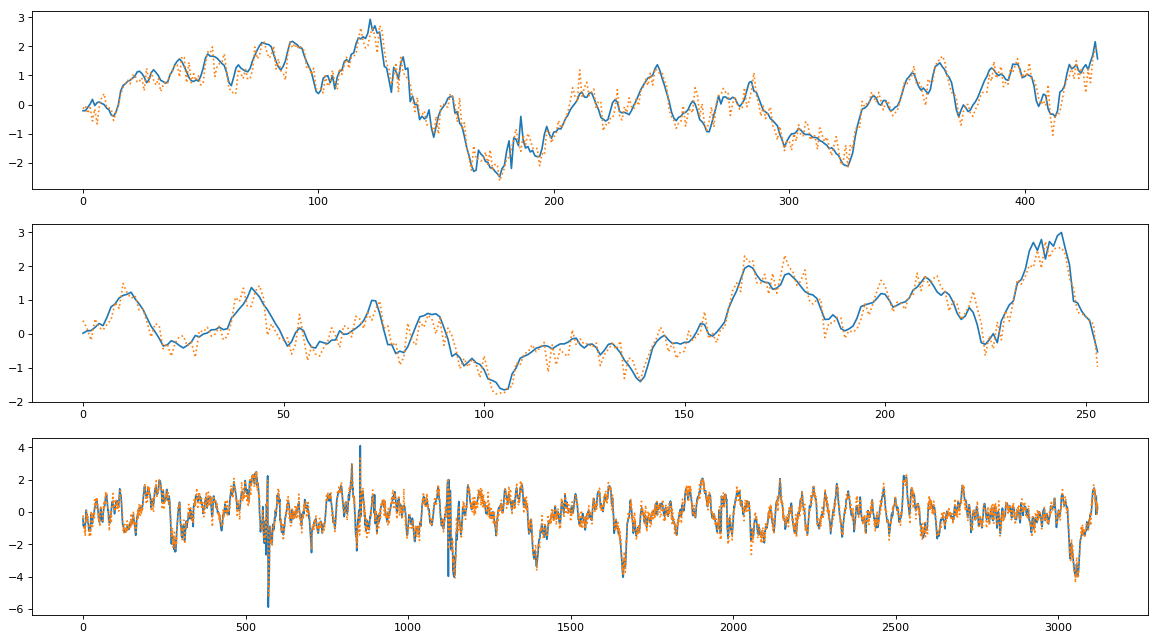

In [14]:
fig = plt.figure(figsize = (18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

count = 0
idx_real = 0
idx_pred = 0
for s in seqlen:
    plt.subplot(len(seqlen), 1, count+1)
    plt.plot(batchdata[(idx_real + crbm1.delay):(idx_real + s), 0], label = 'true', linestyle = '-')
    plt.plot(samp1[idx_pred:(idx_pred + s - crbm1.delay), 0], label = 'predict', linestyle = ':')
    count = count + 1
    idx_real = idx_real + s
    idx_pred = idx_pred + s - crbm1.delay

### Forecasting

In [15]:
n_samples = 100

idx = 200
data_x = batchdata[idx - crbm1.delay - 1:idx, :]

fore1 = crbm1.forecast(data_x, n_samples = n_samples, n_gibbs = 30)

In [16]:
fore1 = np.append(data_x, fore1, axis = 0)

[None, None, None, None]

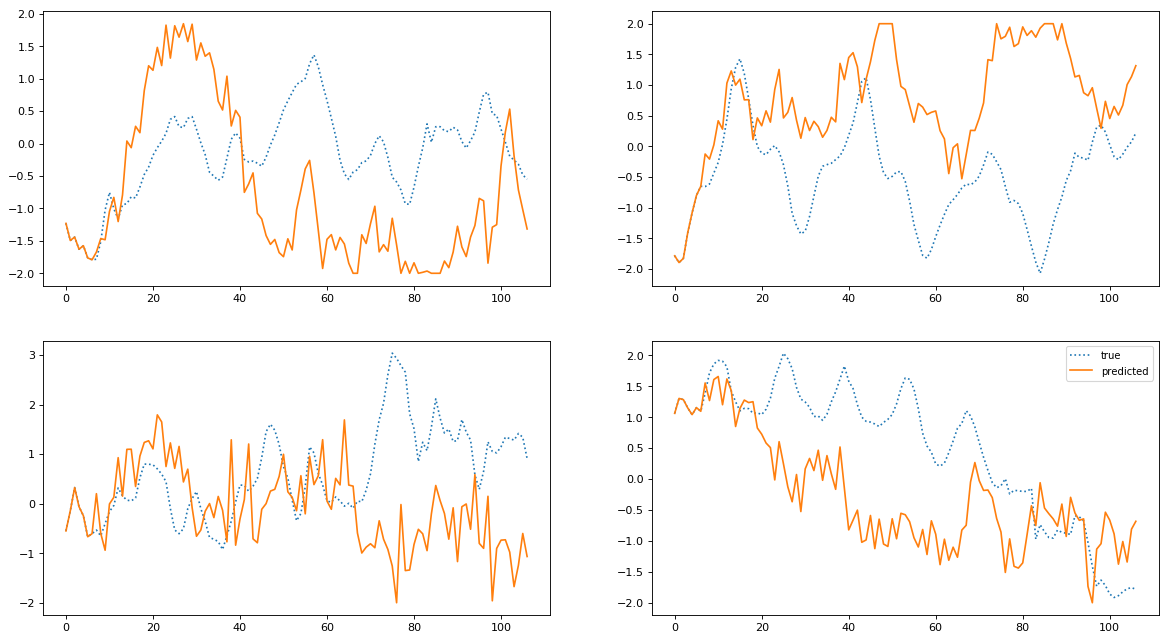

In [17]:
fig = plt.figure(figsize=(18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(2, 2, 1)
plt.plot(batchdata[(idx - crbm1.delay - 1):(idx + n_samples), 0], label = 'true', linestyle = ':')
plt.plot(fore1[:, 0], label = 'predicted', linestyle = '-')

plt.subplot(2, 2, 2)
plt.plot(batchdata[(idx - crbm1.delay - 1):(idx + n_samples), 1], label = 'true', linestyle = ':')
plt.plot(fore1[:, 1], label = 'predicted', linestyle = '-')

plt.subplot(2, 2, 3)
plt.plot(batchdata[(idx - crbm1.delay - 1):(idx + n_samples), 2], label = 'true', linestyle = ':')
plt.plot(fore1[:, 2], label = 'predicted', linestyle = '-')

plt.subplot(2, 2, 4)
plt.plot(batchdata[(idx - crbm1.delay - 1):(idx + n_samples), 3], label = 'true', linestyle = ':')
plt.plot(fore1[:, 3], label = 'predicted', linestyle = '-')

plt.setp(plt.legend().get_texts(), fontsize = 9)